In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import re
import os
import math
import codecs
from collections import Counter
from nltk import word_tokenize,sent_tokenize
from gensim.models import Word2Vec
import spacy
import matplotlib.pyplot as plt
from gensim.models import KeyedVectors
from tqdm import tqdm
import ast
from sklearn.model_selection import train_test_split
from sklearn.metrics import explained_variance_score,mean_squared_error
from feature_extraction import TextFeatureCreator

def roundup(x):
    return int(math.ceil(x / 10.0)) * 10

In [2]:
#import zipfile
#zip_ref = zipfile.ZipFile("clean_newsela_article_files.zip", 'r')
#zip_ref.extractall("clean_newsela")
#zip_ref.close()

In [3]:
#lemmatizer
nlp = spacy.load('en_core_web_sm')

# NN for Cost Function

## Import Section

### Dataset

In [6]:
#import training and test set
df = pd.read_csv("/data/ts_cost_function/newsela_article_feature_scores_V2.csv",sep=";")
df = df.loc[~df["path"].str.contains("LSAT")]
df.head()

,path,feature_sums,regression_score,Mean word length,Mean sentence length,Basic english ratio,Syllables per sentence,Type token ratio,#nouns,#verbs,...,Subordination,Complements,Coordination,Apposition,Passive verbs,Parataxis,Auxiliary Verbs,Negation,Prepositional Phrases,Modifiers
0,/data/ts_cost_function/clean_newsela/kea-extin...,7.687178,0.326461,0.909090,0.306252,1.298557,0.263046,0.845914,0.365935,0.465726,...,0.166589,0.603422,0.202795,0.000000,0.256415,0.0,0.366106,0.201348,0.203278,0.256116
1,/data/ts_cost_function/clean_newsela/australia...,16.690378,0.769983,0.995979,0.841234,1.016792,0.804812,1.071948,1.044247,0.968916,...,0.757223,1.234272,0.796094,1.129397,0.437070,0.0,0.950924,0.686415,0.712792,0.855305
2,/data/ts_cost_function/clean_newsela/city-trol...,8.278258,0.352503,0.955849,0.313058,1.250405,0.273918,0.879494,0.373708,0.457185,...,0.281672,0.360741,0.240468,0.180049,0.278712,0.0,0.440578,0.437714,0.183076,0.306794
3,/data/ts_cost_function/clean_newsela/parkland-...,12.440091,0.538971,0.846982,0.603712,0.943163,0.505093,0.689046,0.619676,0.733049,...,0.333178,1.106273,0.442461,1.325159,0.128207,0.0,0.496858,0.805393,0.391068,0.282251
4,/data/ts_cost_function/clean_newsela/nyc-elect...,9.679800,0.476461,0.947809,0.433960,1.017136,0.382856,0.848541,0.602820,0.547810,...,0.427151,0.551202,0.372263,0.637095,0.493105,0.0,0.440031,0.290406,0.379750,0.316627


### Text Scorer

In [7]:
#import Scorer
ts = TextFeatureCreator("/data/ts_cost_function/LSATtexts.txt")

In [8]:
ts.feature_max

array([4.60611227e+00, 3.10202027e+01, 3.18078798e-01, 4.72160037e+01,
       4.57929050e-01, 7.43301324e+00, 4.42320513e+00, 2.82743677e+00,
       1.52766676e+00, 1.39530366e+00, 1.08050328e+00, 6.62886357e-01,
       1.08484166e+00, 1.20740261e-01, 3.11994654e-01, 1.65647696e-02,
       1.52961211e+00, 1.98660670e-01, 3.44356431e+00, 3.82638558e+00])

## Prepare Input Data 

### Helper Functions

In [4]:
clean_newsela_path = "/data/ts_cost_function/clean_newsela/"
#test_path = test_path[:5] + "clean_" + test_path[5:]

In [4]:
def yield_file_text(df):
    #generator that gives a text each time next(<generator>) is called
    for ind,row in df.iterrows():
        if row["path"] != 'data/LSATtexts.txt':
            yield get_file_text(row)

In [5]:
def get_file_text(row):
    #load the text from the file 
    #(used by yield_file_text)
    path = row["path"]#.split("/")[-1]
    #path= clean_newsela_path+path

    with codecs.open(path, "r",encoding='utf-8', errors='ignore') as f:
        text = f.read()
        #if tokenize:
        #    text = [[word.text.lower() for word in nlp(sent)] for sent in text.split(".")]
        return text

### Lemmatize Text

In [66]:
def create_dataset_file(df,transform_fn,tokenize=False):
    df["text"] = df.apply(lambda row: transform_fn(get_file_text(row,tokenize)),axis=1)
    return df["text"]

def lemmatize_text(text):
    lemma_text=[]
    lemma_sent = []
    for token in nlp(text.lower()):
        if token.is_sent_start == True:
            lemma_text.append(lemma_sent)
            lemma_sent = []
        if token.lemma_ != "-PRON-":
            lemma_sent.append(token.lemma_)
        else:
            lemma_sent.append(token.text)
    return lemma_text
    

In [ ]:
df["text"] = create_dataset_file(df,lemmatize_text,False)
df.to_csv("/data/ts_cost_function/dataset_features_and_text.csv",index=False,sep="|")

### Embed Words with word2vec model

In [3]:
df = pd.read_csv("/data/ts_cost_function/dataset_features_and_text.csv",sep="|")

In [7]:
def prepare_sent_for_word2vec(text_list):
    #join all sentences of the text into list
    #(divide the list into several packages that the spacy lemmatizer can handle)
    text_parts,text_part = [],[]
    text_part_len = 0
    for text in text_list:
        text_len = len(text)
        if text_part_len + text_len < 900000:
            text_part_len += text_len
            text_part += [text]
        else:
            text_parts += [" ".join(text_part)]
            text_part_len = 0
            text_part = []
    return text_parts
    

In [ ]:
text_list = df["text"].values
text_parts = prepare_sent_for_word2vec(text_list)

#Lemmatize each part of the sentence list
hole_lem_text = [lemmatize_text(text) for text in tqdm(text_parts)]
hole_text_sents = np.concatenate(hole_lem_text)

In [104]:
#Train a word2vec model and save it 
lem_word2vec_model = Word2Vec(hole_text_sents, size=50, window=4, min_count=5)
lem_word2vec_model.save("/data/ts_cost_function/word2vec_lem.model")

In [109]:
#Example of the vector of the word "do" 
lem_word2vec_model.wv["do"]

array([ 1.2452955 , -2.1530788 ,  1.7280709 , -0.9999138 , -1.1060853 ,
        0.3383382 , -1.1418934 ,  2.2745516 , -0.2513405 , -0.82757384,
       -0.7249763 ,  1.7150258 ,  2.44857   , -3.9633307 , -1.7148128 ,
       -0.02097538,  4.4459324 ,  0.41563603,  0.43043882, -0.21437858,
       -2.0976083 ,  3.0210202 ,  0.19070254,  2.732013  , -0.02442212,
        3.6682212 ,  0.86653304,  1.7804645 , -0.8916921 ,  2.6753292 ,
       -0.75225073, -2.1348693 ,  1.1207342 , -1.9519628 ,  1.996752  ,
       -2.7731352 ,  1.3074355 ,  3.1944182 , -2.046747  , -0.01732185,
       -0.9517765 ,  0.7973166 ,  0.5044691 , -1.0322701 ,  3.7471695 ,
       -0.25170118,  2.2080932 , -3.2449086 , -3.4603064 , -0.67942697],
      dtype=float32)

### Exchange lemmatized text by word2vec vectors

In [10]:
def text_to_vector(word2vec_model,text):
    vectorized_text = [
            [word2vec_model.wv[word] 
             for word in sent if word in lem_word2vec_model.wv.vocab] 
         for sent in text]
    
    #print(vectorized_text)
    vectorized_text = [sent for sent in vectorized_text if sent]
    return vectorized_text

In [7]:
df = pd.read_csv("/data/ts_cost_function/dataset_features_and_text.csv",sep="|")
df["text"] = df.apply(lambda x: ast.literal_eval(x["text"]),axis=1)

In [8]:
lem_word2vec_model = Word2Vec.load("/data/ts_cost_function/word2vec_lem.model")

In [11]:
vectorized_texts = df.apply(lambda x: text_to_vector(lem_word2vec_model,x["text"]),axis=1)
df["embed"] = vectorized_texts
df.head(1)

,path,feature_sums,regression_score,Mean word length,Mean sentence length,Basic english ratio,Syllables per sentence,Type token ratio,#nouns,#verbs,...,Coordination,Apposition,Passive verbs,Parataxis,Auxiliary Verbs,Negation,Prepositional Phrases,Modifiers,text,embed
0,/data/ts_cost_function/clean_newsela/kea-extin...,7.687178,0.326461,0.90909,0.306252,1.298557,0.263046,0.845914,0.365935,0.465726,...,0.202795,0.0,0.256415,0.0,0.366106,0.201348,0.203278,0.256116,"[[one, of, the, big, threat, to, the, kea, be,...","[[[2.2008598, 2.7345686, 1.5816159, -0.3842493..."


## Explore Dataset

### Helper Functions

In [ ]:
def load_eng_words(eng_words_path="data/20k_words.txt"):
    #load a list with the 20k most common words in english
    #unused?
    with open(eng_words_path,"r") as f:
        data = f.read()
        words = data.split("\n")
        english_df = pd.DataFrame(data=words,columns=["word"])
        english_df["index"] = range(0,len(english_df))
    return english_df

In [ ]:
def sentence_stats(df):
    #shows some statistics of the data
    #(helpful for calulating the tensor size)
    sents = []
    words = []
    removed = []
    for ind,text in enumerate(yield_file_text(df)):
        sent_split = sent_tokenize(text)
        sents.append(len(sent_split))
        words.append([word_tokenize(sent) for sent in sent_split])
        if text.find("This article has been removed") >= 0:
            removed.append(ind)
    
    print("Max #Sents: {}".format(np.max(sents)))
    print("Min #Sents: {}".format(np.min(sents)))
    print("Std #Sents: {}".format(np.std(sents)))
    plt.boxplot(sents)
    plt.show()
    
    return sents,words,removed

### Count the texts words of the text that overlap with the 20k english words

In [ ]:
#word_set = set()
counter = Counter()
for ind,row in tqdm(df.iterrows()):
    lem_text = [token.lemma_ for token in nlp(get_file_text(row))]
    counter.update(lem_text)

In [47]:
#How many of the lemmatized words in the texts match with the 20k english words
word_array = np.array(list(word_set))
english_df = load_eng_words()
len(word_set.intersection(english_df["word"].values))

15419

In [23]:
#with open("data/newsela_word_set.txt","w") as f:
#    f.write(",".join(word_set))
#    f.close()

### Number of Sentences and Words per Sentence

Max #Sents: 204
Min #Sents: 11
Std #Sents: 12.270055057859112


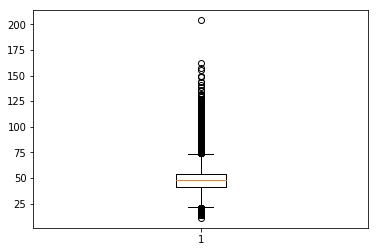

In [22]:
sents,words,removed = sentence_stats(df)

### Distribution of number of sentences in each texts

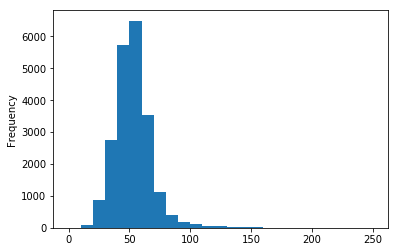

In [36]:
test_len = df.apply(lambda x: len(x["embed"]),axis=1)
test_len.plot.hist(bins=range(0,260,10))

### Distribution of number of words in each sentence

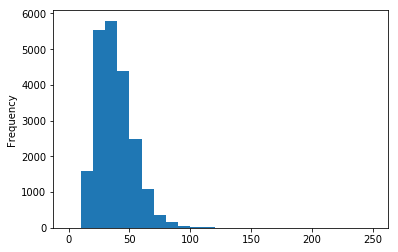

In [37]:
sent_lens = df.apply(lambda x: [len(sent) for sent in x["embed"]],axis=1)
max_sent_len = sent_lens.apply(lambda x: np.max(x))
max_sent_len.plot.hist(bins=range(0,260,10))

**Conclusion**: Due to the reason that most of the sentences are not longer than 100 words and each text also doesn't have more than 100 sentences, we decided to take a 100,100 tensor for texts. We will define later some mask for the RNNs, so that they doesn't go to far.

### Class Ratio

In [75]:
bins       = np.linspace(0, 1, 10)
reg_binned = np.digitize(df["regression_score"].values, bins)

In [76]:
Counter(reg_binned)

Counter({2: 20,
         3: 2088,
         4: 4954,
         5: 5538,
         6: 5285,
         7: 2593,
         8: 873,
         9: 124,
         10: 15})

## TF Estimator Input_Fn

### Add padding at text and sentence level

In [12]:
def embed_padding(embed,max_sent,max_word,embed_size):
    result = np.zeros((max_sent,max_word,embed_size))
    for sent_ind,sent in enumerate(embed[:max_sent]):
        for word_ind,word in enumerate(sent[:max_word]):
            result[sent_ind,word_ind] = word
    return result

In [13]:
df["embed_pad"] = df.apply(
        lambda x: embed_padding(
            x["embed"],
            100,
            100,
            50),
        axis=1)

In [150]:
#np.save('/data/ts_cost_function/embed_pad.npy', df["embed_pad"])
#Result: Memory Error

In [149]:
#arrays = np.stack(df["embed_pad"].values)
#Result: Memory Error

### Text Generators

In [23]:
def word_embed_generator(df):
    #Yields each text and label of the training set
    for ind,row in df.iterrows():
        yield (row["embed_pad"],row["regression_score"])

In [24]:
def prediction_generator(df):
    #Yields only the text for prediction 
    for ind,row in df.iterrows():
        yield (row["embed_pad"],0)

### Define Input Functon

In [25]:
def train_word_emb_fn(df,batch_size,model):
    #Loads the training data for the tf estimator
    max_sent = model.params["text_size"]
    max_word = model.params["sent_size"]
    embed_size = model.params["word_size"]
    #dataset = tf.data.Dataset.from_tensor_slices((dict(df["embed_pad"]), df["regression_score"]))

    dataset = tf.data.Dataset.from_generator(lambda: 
                                             word_embed_generator(df), 
                                             (tf.float64, tf.float64), 
                                             (tf.TensorShape([max_sent,max_word,embed_size]),
                                             tf.TensorShape([])))

    # Shuffle, repeat, and batch the examples.
    dataset = dataset.shuffle(1000).repeat().batch(batch_size)
    #shuffle(1000)
    
    # Return the dataset.
    return dataset

In [26]:
def eval_word_emb_fn(df,batch_size,model):
    #Loads the evaluation data for the tf estimator
    max_sent = model.params["text_size"]
    max_word = model.params["sent_size"]
    embed_size = model.params["word_size"]

    dataset = tf.data.Dataset.from_generator(lambda: 
                                             prediction_generator(df), 
                                             (tf.float64, tf.float64), 
                                             (tf.TensorShape([max_sent,max_word,embed_size]),
                                             tf.TensorShape([])))

    dataset = dataset.batch(batch_size)

    # Return the read end of the pipeline.
    return dataset.make_one_shot_iterator().get_next()

In [425]:
#function test

#dataset = train_word_emb_fn(df,10,100,100,50)
#dataset_iter = dataset.make_one_shot_iterator()
#sess = tf.Session()
#result = sess.run(dataset_iter.get_next())

In [580]:
#function test

#dataset = eval_word_emb_fn(df,10,100,100,50)
#sess = tf.Session()
#result = sess.run(dataset)

In [582]:
#result[0].shape

(10, 100, 100, 50)

## Define Training and Test Set

### Split Data

In [ ]:
#Stratified Train Test Split

bins     = np.linspace(0, 1, 20)
y_binned = np.digitize(df["regression_score"].values, bins)
test_size = 0.2

train_df,test_df = train_test_split(
    df,
    stratify=y_binned,
    test_size=test_size,
    random_state=10)

In [ ]:
#save indixes
index_data = list(zip(*[
            list(np.concatenate([train_df.index,test_df.index])),
            ["train"]*len(train_df)+["test"]*len(test_df)
]))

index_df = pd.DataFrame(
    data=index_data,
    columns=["index","dataset"])

index_df.to_csv("/data/ts_cost_function/train_test_indices.csv",sep=";",index=False)

### Load Splitting

In [14]:
index_df = pd.read_csv("/data/ts_cost_function/train_test_indices.csv",sep=";")

In [15]:
train_df = df.iloc[index_df.loc[index_df["dataset"] == "train"]["index"].values]
test_df = df.iloc[index_df.loc[index_df["dataset"] == "test"]["index"].values]

In [16]:
train_df.head(1)

,path,feature_sums,regression_score,Mean word length,Mean sentence length,Basic english ratio,Syllables per sentence,Type token ratio,#nouns,#verbs,...,Apposition,Passive verbs,Parataxis,Auxiliary Verbs,Negation,Prepositional Phrases,Modifiers,text,embed,embed_pad
13620,/data/ts_cost_function/clean_newsela/planet-ni...,17.80152,0.67148,0.919342,0.784718,1.041918,0.735701,0.819199,0.842614,0.80318,...,0.788785,0.610511,2.874718,0.591498,1.198502,0.643021,0.68447,"[[an, answer, for, planet, ', strange, alignme...","[[[6.1390705, 2.7747629, -2.6474686, -0.170415...","[[[6.139070510864258, 2.7747628688812256, -2.6..."


## NN Architecture

### Embedding + Sentence RNN + Text RNN

In [17]:
model_path = "/data/ts_cost_function/model_emb_rnn_rnn"

hyperparameter = {
    "text_size" : 100,
    "sent_size" : 100,
    "word_size" : 50,
    "learning_rate": 0.01,#0.0001
    "sent_hidden_state_size": 64,
    "text_hidden_state_size": 64
}

![architecture](../paper/jupyter_results/architecture_rnn_rnn.png)

#### Model Function

In [199]:
def model_emb_rnn_rnn_fn(features, labels, mode, params):
    #Model Function of the architecture
    
    batch_size = global_batch_size
    text_size = params["text_size"]
    sent_size = params["sent_size"]
    word_size = params["word_size"]
    learn_rate = params["learning_rate"]
    sent_hidden_state_size = params["sent_hidden_state_size"]
    text_hidden_state_size = params["text_hidden_state_size"]
    #n_steps_summary = params["every_n_steps_summarize"]
    #model_path = params["model_path"]
    
    

    
    #Mask the length of each sentence 
    word_mask = tf.reduce_max(
        tf.count_nonzero(
            tf.reshape(
                features,
                [batch_size*text_size,sent_size,word_size]),
            1),
        1)
    #Mask the length of each text
    sent_mask = tf.count_nonzero(
        tf.reduce_max(
            tf.count_nonzero(
                features,
                2),
            2),
        1)
    
    #Concat all sentences of all texts of a batch together to use word_mask
    concat_sents = tf.reshape(features,[batch_size*text_size,sent_size,word_size])
    
    
    #LSTM for each word in a sentence
    with tf.variable_scope('word_cell'):
        word_cell = tf.contrib.rnn.BasicLSTMCell(num_units=sent_hidden_state_size, state_is_tuple=True)
        word_outputs, word_last_states = tf.nn.dynamic_rnn(
            cell=word_cell,
            dtype=tf.float64,
            sequence_length=word_mask,
            #initial_state=init_state,
            inputs=concat_sents)
        
        reshaped_word_last_states = tf.reshape(word_last_states.c,[batch_size,text_size,sent_hidden_state_size])
    
    #LSTM for each sentence in a text
    with tf.variable_scope('sent_cell'):
        sent_cell = tf.contrib.rnn.BasicLSTMCell(num_units=text_hidden_state_size, state_is_tuple=False)
        sent_outputs, sent_last_states = tf.nn.dynamic_rnn(
            cell=sent_cell,
            dtype=tf.float64,
            sequence_length=sent_mask,
            inputs=reshaped_word_last_states)
        
    #summary
    for name,cell in [("word",word_cell),("sent",sent_cell)]:
        one_kernel, one_bias = cell.variables
        # I think TensorBoard handles summaries with the same name fine.
        tf.summary.histogram(name+"_kernel", one_kernel)
        tf.summary.histogram(name+"_bias", one_bias)
    
    #shrink last hidden state of each text
    pred_value = tf.layers.dense(inputs=sent_last_states, units=1, activation=None)
    
    predictions = {
        # Generate predictions (for PREDICT and EVAL mode)
        "logits": pred_value,
        "word_outputs":word_outputs,
        "sent_outputs":sent_outputs,
        "word_mask":word_mask,
        "sent_mask":sent_mask
        
    }
    
    if mode == tf.estimator.ModeKeys.PREDICT:
        return tf.estimator.EstimatorSpec(mode, predictions=predictions)
    
    #MSE for loss
    reshaped_labels = tf.reshape(labels,[batch_size,1])
    cost = tf.losses.mean_squared_error(reshaped_labels,pred_value)
    mse = tf.metrics.mean_squared_error(reshaped_labels,pred_value)
    
    tf.summary.scalar('mse', mse[1])
    
    if mode == tf.estimator.ModeKeys.TRAIN:
        #Adam Optimizer
        optimizer = tf.train.AdamOptimizer(
            learning_rate=learn_rate)
        train_op = optimizer.minimize(
            loss=cost,
            global_step=tf.train.get_global_step())
        
        return tf.estimator.EstimatorSpec(
            mode=mode, 
            loss=cost,
            train_op=train_op)
    
    print(cost)
    eval_metric_ops = {
      "MSE": mse}
    return tf.estimator.EstimatorSpec(
      mode=mode, loss=cost, eval_metric_ops=eval_metric_ops)
    

#### Create Estimator

In [200]:
#tf.reset_default_graph()

#Change the checkpoint config
checkpointing_config = tf.estimator.RunConfig(
    #save_checkpoints_secs = 60*10,  # Save checkpoints every 10 minutes.
    keep_checkpoint_max = 5,       # Retain the 10 most recent checkpoints.
    save_summary_steps=10
)

#Define Estimator
model_emb_rnn_rnn = tf.estimator.Estimator(
    model_fn=model_emb_rnn_rnn_fn, 
    model_dir=model_path,
    params=hyperparameter,
    config=checkpointing_config)

tf.logging.set_verbosity(tf.logging.INFO)

INFO:tensorflow:Using config: {'_model_dir': '/data/ts_cost_function/model_emb_rnn_rnn', '_save_checkpoints_secs': 600, '_task_type': 'worker', '_save_summary_steps': 10, '_evaluation_master': '', '_keep_checkpoint_max': 5, '_log_step_count_steps': 100, '_master': '', '_keep_checkpoint_every_n_hours': 10000, '_session_config': None, '_tf_random_seed': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fbb7444fc50>, '_num_ps_replicas': 0, '_is_chief': True, '_num_worker_replicas': 1, '_save_checkpoints_steps': None, '_service': None, '_global_id_in_cluster': 0, '_task_id': 0, '_train_distribute': None}


#### Train Model

In [59]:
train_batch_size = 10
global_batch_size = train_batch_size
train_steps = 400

training = model_emb_rnn_rnn.train(
        input_fn=lambda:train_word_emb_fn(
            train_df,
            train_batch_size,
            model_emb_rnn_rnn),
        #hooks=[logging_hook],
        max_steps=train_steps)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1 into /data/ts_cost_function/model_emb_rnn_rnn_V2/model.ckpt.
INFO:tensorflow:loss = 0.05514086, step = 0
INFO:tensorflow:global_step/sec: 2.95608
INFO:tensorflow:loss = 0.022447268, step = 100 (33.831 sec)
INFO:tensorflow:global_step/sec: 2.96803
INFO:tensorflow:loss = 0.017438645, step = 200 (33.694 sec)
INFO:tensorflow:global_step/sec: 2.98193
INFO:tensorflow:loss = 0.006903635, step = 300 (33.533 sec)
INFO:tensorflow:Saving checkpoints for 400 into /data/ts_cost_function/model_emb_rnn_rnn_V2/model.ckpt.
INFO:tensorflow:Loss for final step: 0.00535983.


#### Train and Evaluate

In [ ]:
train_batch_size = 10
test_batch_size = 100
train_steps = 100
eval_steps = 600
start_steps = 1200

log = []
for loop in range(1,101):
    
    global_batch_size = train_batch_size
    model_emb_rnn_rnn.train(
        input_fn=lambda:train_word_emb_fn(
            train_df,
            global_batch_size,
            model_emb_rnn_rnn),
        steps=train_steps)
    
    global_batch_size = test_batch_size
    #Evaluate Training
    train_evaluation = model_emb_rnn_rnn.evaluate(
        input_fn=lambda:train_word_emb_fn(
            train_df.sample(eval_steps),
            global_batch_size,
            model_emb_rnn_rnn
            ),
        steps=eval_steps)
    #Evaluate Test
    test_evaluation = model_emb_rnn_rnn.evaluate(
        input_fn=lambda:train_word_emb_fn(
            test_df.sample(eval_steps),
            global_batch_size,
            model_emb_rnn_rnn
            ),
        steps=eval_steps)
    
    log.append([
        1200+loop*train_steps,
        train_evaluation["MSE"],
        test_evaluation["MSE"]]
    )
    
    #hooks=[logging_hook])

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1 into /data/ts_cost_function/model_emb_rnn_rnn/model.ckpt.
INFO:tensorflow:loss = 0.2771515, step = 0
INFO:tensorflow:train_loss = 0.2771515
INFO:tensorflow:train_loss = 0.023276616 (2.685 sec)
INFO:tensorflow:train_loss = 0.04517076 (2.366 sec)
INFO:tensorflow:train_loss = 0.029089173 (2.298 sec)
INFO:tensorflow:train_loss = 0.045278188 (2.212 sec)
INFO:tensorflow:train_loss = 0.04433508 (2.283 sec)
INFO:tensorflow:train_loss = 0.05917585 (2.294 sec)
INFO:tensorflow:train_loss = 0.021769533 (2.278 sec)
INFO:tensorflow:train_loss = 0.04654789 (2.365 sec)
INFO:tensorflow:train_loss = 0.007927015 (2.254 sec)
INFO:tensorflow:Saving checkpoints for 100 into /data/ts_cost_function/model_emb_rnn_rnn/model.ckpt.
INFO:ten

INFO:tensorflow:train_loss = 0.01590827 (2.332 sec)
INFO:tensorflow:train_loss = 0.012267985 (2.313 sec)
INFO:tensorflow:Saving checkpoints for 300 into /data/ts_cost_function/model_emb_rnn_rnn/model.ckpt.
INFO:tensorflow:Loss for final step: 0.011350348.
INFO:tensorflow:Calling model_fn.
Tensor("mean_squared_error/value:0", shape=(), dtype=float32)
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-09-02-18:52:11
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /data/ts_cost_function/model_emb_rnn_rnn/model.ckpt-300
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Evaluation [200/2000]
INFO:tensorflow:Evaluation [400/2000]
INFO:tensorflow:Evaluation [600/2000]
INFO:tensorflow:Evaluation [1000/2000]
INFO:tensorflow:Evaluation [1200/2000]
INFO:tensorflow:Evaluation [1400/2000]
INFO:tensorflow:Evaluation [1600/2000]
INFO:tensorflow:Evaluation [1800/2000]
INFO:tensorflow:Evaluat

INFO:tensorflow:Evaluation [1000/2000]
INFO:tensorflow:Evaluation [1200/2000]
INFO:tensorflow:Evaluation [1400/2000]
INFO:tensorflow:Evaluation [1600/2000]
INFO:tensorflow:Evaluation [1800/2000]
INFO:tensorflow:Evaluation [2000/2000]
INFO:tensorflow:Finished evaluation at 2018-09-02-21:30:10
INFO:tensorflow:Saving dict for global step 500: MSE = 0.011740139, global_step = 500, loss = 0.011740145
INFO:tensorflow:Calling model_fn.
Tensor("mean_squared_error/value:0", shape=(), dtype=float32)
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-09-02-21:30:11
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /data/ts_cost_function/model_emb_rnn_rnn/model.ckpt-500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Evaluation [200/2000]
INFO:tensorflow:Evaluation [400/2000]
INFO:tensorflow:Evaluation [600/2000]
INFO:tensorflow:Evaluation [800/2000]
INFO:tensorflow:Evaluation [1000/2000

INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Evaluation [200/2000]
INFO:tensorflow:Evaluation [400/2000]
INFO:tensorflow:Evaluation [600/2000]
INFO:tensorflow:Evaluation [800/2000]
INFO:tensorflow:Evaluation [1000/2000]
INFO:tensorflow:Evaluation [1200/2000]
INFO:tensorflow:Evaluation [1400/2000]
INFO:tensorflow:Evaluation [1600/2000]
INFO:tensorflow:Evaluation [1800/2000]
INFO:tensorflow:Evaluation [2000/2000]
INFO:tensorflow:Finished evaluation at 2018-09-03-00:10:29
INFO:tensorflow:Saving dict for global step 700: MSE = 0.009870282, global_step = 700, loss = 0.009870279
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /data/ts_cost_function/model_emb_rnn_rnn/model.ckpt-700
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoi

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /data/ts_cost_function/model_emb_rnn_rnn/model.ckpt-900
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 901 into /data/ts_cost_function/model_emb_rnn_rnn/model.ckpt.
INFO:tensorflow:loss = 0.002064695, step = 900
INFO:tensorflow:train_loss = 0.002064695
INFO:tensorflow:train_loss = 0.009203932 (2.771 sec)
INFO:tensorflow:train_loss = 0.004165014 (2.578 sec)
INFO:tensorflow:train_loss = 0.003894965 (2.502 sec)
INFO:tensorflow:train_loss = 0.0034611716 (2.408 sec)
INFO:tensorflow:train_loss = 0.0030654534 (2.686 sec)
INFO:tensorflow:train_loss = 0.006258432 (2.393 sec)
INFO:tensorflow:train_loss = 0.006973669 (2.380 sec)
INFO:tensorflow:train_loss = 0.006646942 (2.404 sec)
INFO:tensorflow:train_loss = 0.0037444842 (2.397 sec)
INFO:tensorflow:Saving checkpoints for 1000 into /data/ts_cost_functi

INFO:tensorflow:train_loss = 0.0055414713 (2.514 sec)
INFO:tensorflow:Saving checkpoints for 1200 into /data/ts_cost_function/model_emb_rnn_rnn/model.ckpt.
INFO:tensorflow:Loss for final step: 0.0062746443.
INFO:tensorflow:Calling model_fn.
Tensor("mean_squared_error/value:0", shape=(), dtype=float32)
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-09-03-04:28:52
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /data/ts_cost_function/model_emb_rnn_rnn/model.ckpt-1200
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Evaluation [200/2000]
INFO:tensorflow:Evaluation [400/2000]
INFO:tensorflow:Evaluation [600/2000]


In [92]:
steps,train_result,test_result = list(zip(*log))

Text(0,0.5,'MSE')

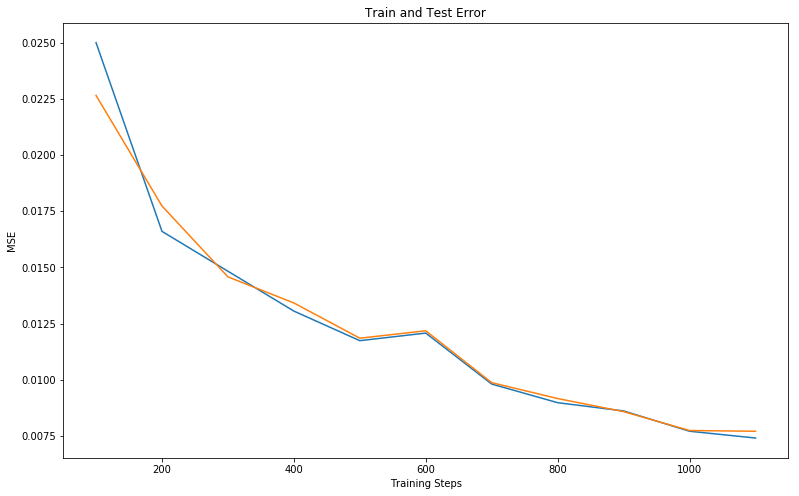

In [98]:
plt.figure(figsize=(13,8))
plt.plot(
    steps,
    list(zip(*[train_result,test_result])))
plt.title("Train and Test Error")
plt.xlabel("Training Steps")
plt.ylabel("MSE")

#### Evaluate

In [60]:
global_batch_size = 100

evaluation = model_emb_rnn_rnn.evaluate(
    input_fn=lambda:train_word_emb_fn(
        test_df,
        global_batch_size,
        model_emb_rnn_rnn
        ),
    steps=40)

INFO:tensorflow:Calling model_fn.
Tensor("mean_squared_error/value:0", shape=(), dtype=float32)
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-09-06-14:15:38
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /data/ts_cost_function/model_emb_rnn_rnn_V2/model.ckpt-400
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Evaluation [4/40]
INFO:tensorflow:Evaluation [8/40]
INFO:tensorflow:Evaluation [12/40]
INFO:tensorflow:Evaluation [16/40]
INFO:tensorflow:Evaluation [20/40]
INFO:tensorflow:Evaluation [24/40]
INFO:tensorflow:Evaluation [28/40]
INFO:tensorflow:Evaluation [32/40]
INFO:tensorflow:Evaluation [36/40]
INFO:tensorflow:Evaluation [40/40]
INFO:tensorflow:Finished evaluation at 2018-09-06-14:16:38
INFO:tensorflow:Saving dict for global step 400: MSE = 0.0071799085, global_step = 400, loss = 0.00717991


In [64]:
evaluation["MSE"]

0.0083781

#### Predict

In [107]:
global_batch_size = 100

pred_generator = model_emb_rnn_rnn.predict(
    input_fn=lambda:eval_word_emb_fn(
        test_df,
        global_batch_size,
        model_emb_rnn_rnn),
    yield_single_examples=False)

preds = []
for i in range(40):
    outputs = next(pred_generator)
    preds.append((outputs["logits"],outputs["word_outputs"],outputs["sent_outputs"]))
pred_reg,word_outputs,sent_outputs = list(zip(*preds))
#pred_reg = np.concatenate(pred_reg)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /data/ts_cost_function/model_emb_rnn_rnn/model.ckpt-17000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


In [111]:
act = test_df.iloc[:4000]["regression_score"].values
pred_reg = np.concatenate(pred_reg)
mean_squared_error(pred_reg,act)

0.0004332120405283689

{'boxes': [<matplotlib.lines.Line2D at 0x7fae986b7438>],
 'caps': [<matplotlib.lines.Line2D at 0x7fae986b7e48>,
 'fliers': [<matplotlib.lines.Line2D at 0x7fae986c5b00>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7fae986c56d8>],
 'whiskers': [<matplotlib.lines.Line2D at 0x7fae986b7588>,
  <matplotlib.lines.Line2D at 0x7fae986b7a20>]}

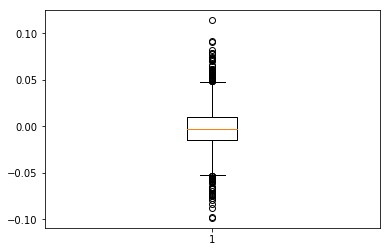

In [28]:
diff = act - preds
plt.boxplot(diff)

## Explore Results

In [29]:
eval_df = test_df[test_df.columns[:-2]].iloc[:4000].copy()
eval_df["prediction"] = preds

### Bias compared to regression score

In [30]:
eval_df["bias"] = np.abs((eval_df["regression_score"] - eval_df["prediction"]).values)

In [78]:
bins     = np.linspace(0, 1, 10)
reg_binned = np.digitize(eval_df["regression_score"].values, bins)
eval_df["reg_bin"] = reg_binned
Counter(reg_binned)

Counter({2: 6, 3: 387, 4: 922, 5: 1023, 6: 1005, 7: 466, 8: 167, 9: 21, 10: 3})

/usr/local/lib/python3.5/dist-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


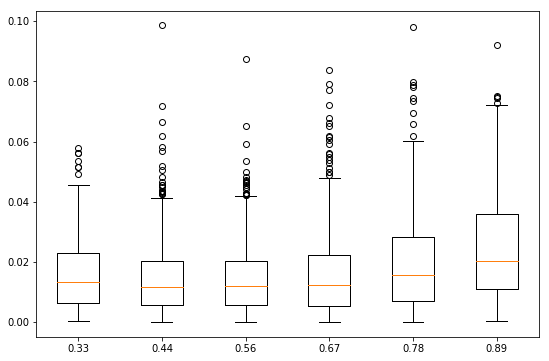

In [86]:
#Exclude 1,2,9,10 , because there are to few samples
data = [eval_df.loc[eval_df["reg_bin"] == i]["bias"].values for i in range(3,9)]

# Create a figure instance
fig = plt.figure(1, figsize=(9, 6))

# Create an axes instance
ax = fig.add_subplot(111)

ax.boxplot(data)
ax.set_xticklabels(np.round(bins[3:9],2))
fig.show()

### Assess weights and bias of RNN

In [104]:
import seaborn as sns

In [6]:
meta_path = '/data/ts_cost_function/model_emb_rnn_rnn/model.ckpt-17000.meta'
ckpt_path = '/data/ts_cost_function/model_emb_rnn_rnn/model.ckpt-17000'
#tf.reset_default_graph()

with tf.Session() as sess:
    #tf.reset_default_graph()
    # Restore graph
    saver = tf.train.import_meta_graph(meta_path)

    saver.restore(sess, ckpt_path)
    
    g = tf.get_default_graph()
    w1 = g.get_tensor_by_name('word_cell/rnn/basic_lstm_cell/kernel:0')
    
    word_weights = sess.run(w1)

INFO:tensorflow:Restoring parameters from /data/ts_cost_function/model_emb_rnn_rnn/model.ckpt-17000


In [110]:
model_emb_rnn_rnn.get_variable_names()

['beta1_power',
 'beta2_power',
 'dense/bias',
 'dense/bias/Adam',
 'dense/bias/Adam_1',
 'dense/kernel',
 'dense/kernel/Adam',
 'dense/kernel/Adam_1',
 'global_step',
 'sent_cell/rnn/basic_lstm_cell/bias',
 'sent_cell/rnn/basic_lstm_cell/bias/Adam',
 'sent_cell/rnn/basic_lstm_cell/bias/Adam_1',
 'sent_cell/rnn/basic_lstm_cell/kernel',
 'sent_cell/rnn/basic_lstm_cell/kernel/Adam',
 'sent_cell/rnn/basic_lstm_cell/kernel/Adam_1',
 'word_cell/rnn/basic_lstm_cell/bias',
 'word_cell/rnn/basic_lstm_cell/bias/Adam',
 'word_cell/rnn/basic_lstm_cell/bias/Adam_1',
 'word_cell/rnn/basic_lstm_cell/kernel',
 'word_cell/rnn/basic_lstm_cell/kernel/Adam',
 'word_cell/rnn/basic_lstm_cell/kernel/Adam_1']

In [26]:
#[input_depth + h_depth, 4 * self._num_units]
#[50+64,4*64]
word_weights = model_emb_rnn_rnn.get_variable_value('word_cell/rnn/basic_lstm_cell/kernel')
word_bias = model_emb_rnn_rnn.get_variable_value('word_cell/rnn/basic_lstm_cell/bias')

In [29]:
w_input, w_new_input, w_forget, w_output = np.split(word_weights, 4, axis=1)
b_input, b_new_input, b_forget, b_output = np.split(word_bias, 4)

In [31]:
b_input

array([-0.01243733, -0.04722974, -0.01132882,  0.01185403, -0.00185262,
       -0.00814206, -0.01425064, -0.01345138, -0.03307504, -0.0315694 ,
       -0.00534911, -0.02080592, -0.01195673, -0.00242523, -0.00250495,
       -0.00607754, -0.00981787, -0.00429628, -0.01017649, -0.01013114,
       -0.01365585, -0.00521995, -0.00333375, -0.01369343, -0.01659626,
       -0.00075517,  0.0061084 , -0.0041189 ,  0.00302902, -0.01099612,
       -0.01197433, -0.00203431, -0.00749625, -0.00236968, -0.00358325,
       -0.00731629, -0.03668988, -0.00549869, -0.01294233, -0.01205942,
       -0.01953824, -0.00131991, -0.03187135,  0.00791373, -0.01037724,
       -0.00740926, -0.01344833, -0.02054362, -0.00286691, -0.01487905,
       -0.01009436, -0.01288698, -0.00325413, -0.03491056, -0.03210759,
       -0.01356852, -0.03377969, -0.00856886,  0.00242031, -0.00719347,
       -0.02523049, -0.03052545, -0.02465324, -0.00482668])

In [118]:
word_weights.shape

(128, 256)

### LSTMVis

In [20]:
import h5py

In [21]:
def exchange_word_by_index(word_dic,text):
    #index_text = np.zeros((100,100))
    index_text = []
    for sent_ind,sent in enumerate(text):
        if sent_ind < 100:
            for word_ind,word in enumerate(sent):
                if word_ind < 100:
                    #index_text[sent_ind,word_ind] = word_dic[word]
                    index_text.append(word_dic[word])
            index_text.append(word_dic["<Zero>"])
    return index_text

In [201]:
global_batch_size = 100

pred_generator = model_emb_rnn_rnn.predict(
    input_fn=lambda:eval_word_emb_fn(
        test_df,
        global_batch_size,
        model_emb_rnn_rnn),
    yield_single_examples=False)

preds = []
for i in range(40):
    outputs = next(pred_generator)
    preds.append((
        outputs["logits"],
        outputs["word_outputs"],
        outputs["sent_outputs"],
        outputs["word_mask"],
        outputs["sent_mask"],))
pred_reg,word_outputs,sent_outputs,word_mask,sent_mask = list(zip(*preds))
#pred_reg = np.concatenate(pred_reg)
word_outputs = np.concatenate(word_outputs)
word_mask = np.concatenate(word_mask)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /data/ts_cost_function/model_emb_rnn_rnn/model.ckpt-17000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


In [263]:
#word_dictionary
words = np.concatenate(np.concatenate(test_df["text"].values))
word_dic = {}
for i,word in enumerate(set(words)):
    try:
        vector = lem_word2vec_model.wv[word]
        word_dic[word] = i+1
    except KeyError:
        pass
word_dic["<Zero>"] = 0
#LSTMVis Word Dictionary
lstmvis_word_dic = [word+" "+str(ind) for ind,word in zip(*[word_dic.values(),word_dic.keys()])]
with open("/data/ts_cost_function/lstmvis/words.dic","w") as f:
    f.write("\n".join(lstmvis_word_dic))
    f.close()

In [237]:
reshaped_texts = np.concatenate(
    test_df.iloc[:4000].apply(
        lambda x: x["text"][:100],axis=1).values)

In [260]:
lstmvis_sents = []
lstmvis_states = []
#word_masks = []
for ind,sent in enumerate(reshaped_texts):
    sent = [word for word in sent if word in word_dic]
    sent_len = len(sent)
    lstmvis_states.append(word_outputs[ind][:sent_len])
    #word_masks.append(word_mask[ind])
    lstmvis_sents.append([word_dic[word] for ind,word in enumerate(sent) if ind < 100])
    
    #add a zero value in between
    lstmvis_states.append(np.zeros((1,64)))
    lstmvis_sents.append([0])

In [262]:
concat_lstmvis_states = np.concatenate(lstmvis_states)
concat_lstmvis_sents = np.concatenate(lstmvis_sents)

In [267]:
print(concat_lstmvis_states.shape,concat_lstmvis_sents.shape)
print(concat_lstmvis_states[:2],concat_lstmvis_sents[:2])

(3449298, 64) (3449298,)
[[ 2.02177831e-01 -2.49047419e-01 -1.34101815e-01  4.07836192e-02
   3.49444968e-02 -6.89300134e-02 -1.94031798e-02 -7.94780168e-02
  -6.75784276e-02 -3.41325053e-01 -7.84869556e-02  6.34849581e-02
   4.48559571e-03 -2.92622758e-01  5.60895651e-02  5.26947915e-02
   6.26749826e-02  1.33358226e-02  7.93932415e-03 -1.91616819e-02
  -1.08848346e-01  5.03293476e-02 -1.06609793e-01  7.95189919e-02
  -7.94569896e-02  1.27195724e-02  1.18266550e-02  7.66252124e-02
  -2.12173941e-01 -5.37940656e-02 -1.62614092e-01  2.79861828e-02
   2.25610323e-02 -1.12739788e-01  1.63254862e-01 -1.26283074e-01
   2.07020585e-02 -1.00476181e-01  2.53147693e-01  1.36791025e-01
  -2.00653753e-01  1.95185048e-02 -6.76889608e-02  1.76496990e-01
  -6.82603836e-02  2.13814999e-01 -8.63600123e-02 -7.07173452e-02
  -1.73039320e-01 -4.34077092e-02 -4.32427728e-02  1.69621475e-02
  -9.05755758e-03 -3.42434698e-01  7.04581268e-02 -4.75017164e-02
  -1.72316772e-01  1.30225848e-01  7.42587160e-02 -

In [268]:
f = h5py.File("/data/ts_cost_function/lstmvis/states.h5", "w")
f["states1"] = concat_lstmvis_states
f.close()

In [269]:
f = h5py.File("/data/ts_cost_function/lstmvis/train.h5", "w")
f["word_ids"] = concat_lstmvis_sents
f.close()